# Earthquake Prediction

#### Table of Contents
0. Setup
1. Data Analysis
2. Data Preparation
3. Model Training
4. Model Evaluation

In [40]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error

## 0. Setup

In [41]:
filepath = './data/earthquakes.csv'

## 1. Data Analysis

In [42]:
df = pd.read_csv(filepath)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-08-18T11:29:57.850Z,18.987499,-155.431671,33.680,2.76,ml,47.0,225.0,NaN,0.13,...,2022-08-18T12:23:58.514Z,"17 km ESE of Naalehu, Hawaii",earthquake,0.55,0.930,0.630,4.0,automatic,hv,hv
1,2022-08-18T09:39:19.617Z,27.554600,139.788700,496.853,4.80,mb,122.0,45.0,5.542,0.62,...,2022-08-18T10:04:50.040Z,"Bonin Islands, Japan region",earthquake,10.78,6.395,0.026,455.0,reviewed,us,us
2,2022-08-18T09:28:29.331Z,23.962600,122.409900,24.596,4.40,mb,28.0,116.0,0.744,0.51,...,2022-08-18T10:21:12.040Z,"81 km SW of Yonakuni, Japan",earthquake,4.92,6.785,0.155,12.0,reviewed,us,us
3,2022-08-18T07:46:27.540Z,0.340300,124.375200,166.522,5.40,mww,83.0,47.0,2.111,1.00,...,2022-08-18T09:50:10.951Z,"118 km SSW of Tomohon, Indonesia",earthquake,6.32,4.939,0.071,19.0,reviewed,us,us
4,2022-08-18T07:21:54.330Z,18.422600,-64.788600,97.000,3.78,md,16.0,350.0,0.182,0.03,...,2022-08-18T07:48:53.040Z,"10 km N of Cruz Bay, U.S. Virgin Islands",earthquake,5.57,1.010,0.110,9.0,reviewed,pr,pr


In [43]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,15609.000000,15609.000000,15609.000000,15608.000000,11353.000000,12556.000000,11367.000000,15609.000000,9908.000000,15609.000000,10355.000000,10693.000000
mean,37.440961,-107.587888,22.208975,1.706832,22.811151,114.137972,0.658994,0.289966,2.091467,7.235612,0.211688,19.264472
std,18.915086,70.016140,57.789274,1.299868,20.125595,57.536459,2.171913,0.277736,3.412744,585.071370,0.337352,36.855866
min,-65.352200,-179.987200,-3.630000,-1.430000,2.000000,13.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.756333,-148.356300,4.000000,0.810000,11.000000,70.960000,0.024000,0.100000,0.280000,0.470000,0.101000,5.000000
50%,38.141500,-118.029800,8.200000,1.370000,17.000000,102.100000,0.058750,0.170000,0.490000,0.800000,0.156000,11.000000
75%,50.999600,-116.313167,14.320000,2.200000,27.000000,145.625000,0.158900,0.440000,1.360000,1.900000,0.220000,20.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,40.927000,2.460000,26.400000,73091.100000,5.320000,741.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15609 entries, 0 to 15608
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             15609 non-null  object 
 1   latitude         15609 non-null  float64
 2   longitude        15609 non-null  float64
 3   depth            15609 non-null  float64
 4   mag              15608 non-null  float64
 5   magType          15608 non-null  object 
 6   nst              11353 non-null  float64
 7   gap              12556 non-null  float64
 8   dmin             11367 non-null  float64
 9   rms              15609 non-null  float64
 10  net              15609 non-null  object 
 11  id               15609 non-null  object 
 12  updated          15609 non-null  object 
 13  place            15600 non-null  object 
 14  type             15609 non-null  object 
 15  horizontalError  9908 non-null   float64
 16  depthError       15609 non-null  float64
 17  magError    

In [45]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   1
magType               1
nst                4256
gap                3053
dmin               4242
rms                   0
net                   0
id                    0
updated               0
place                 9
type                  0
horizontalError    5701
depthError            0
magError           5254
magNst             4916
status                0
locationSource        0
magSource             0
dtype: int64

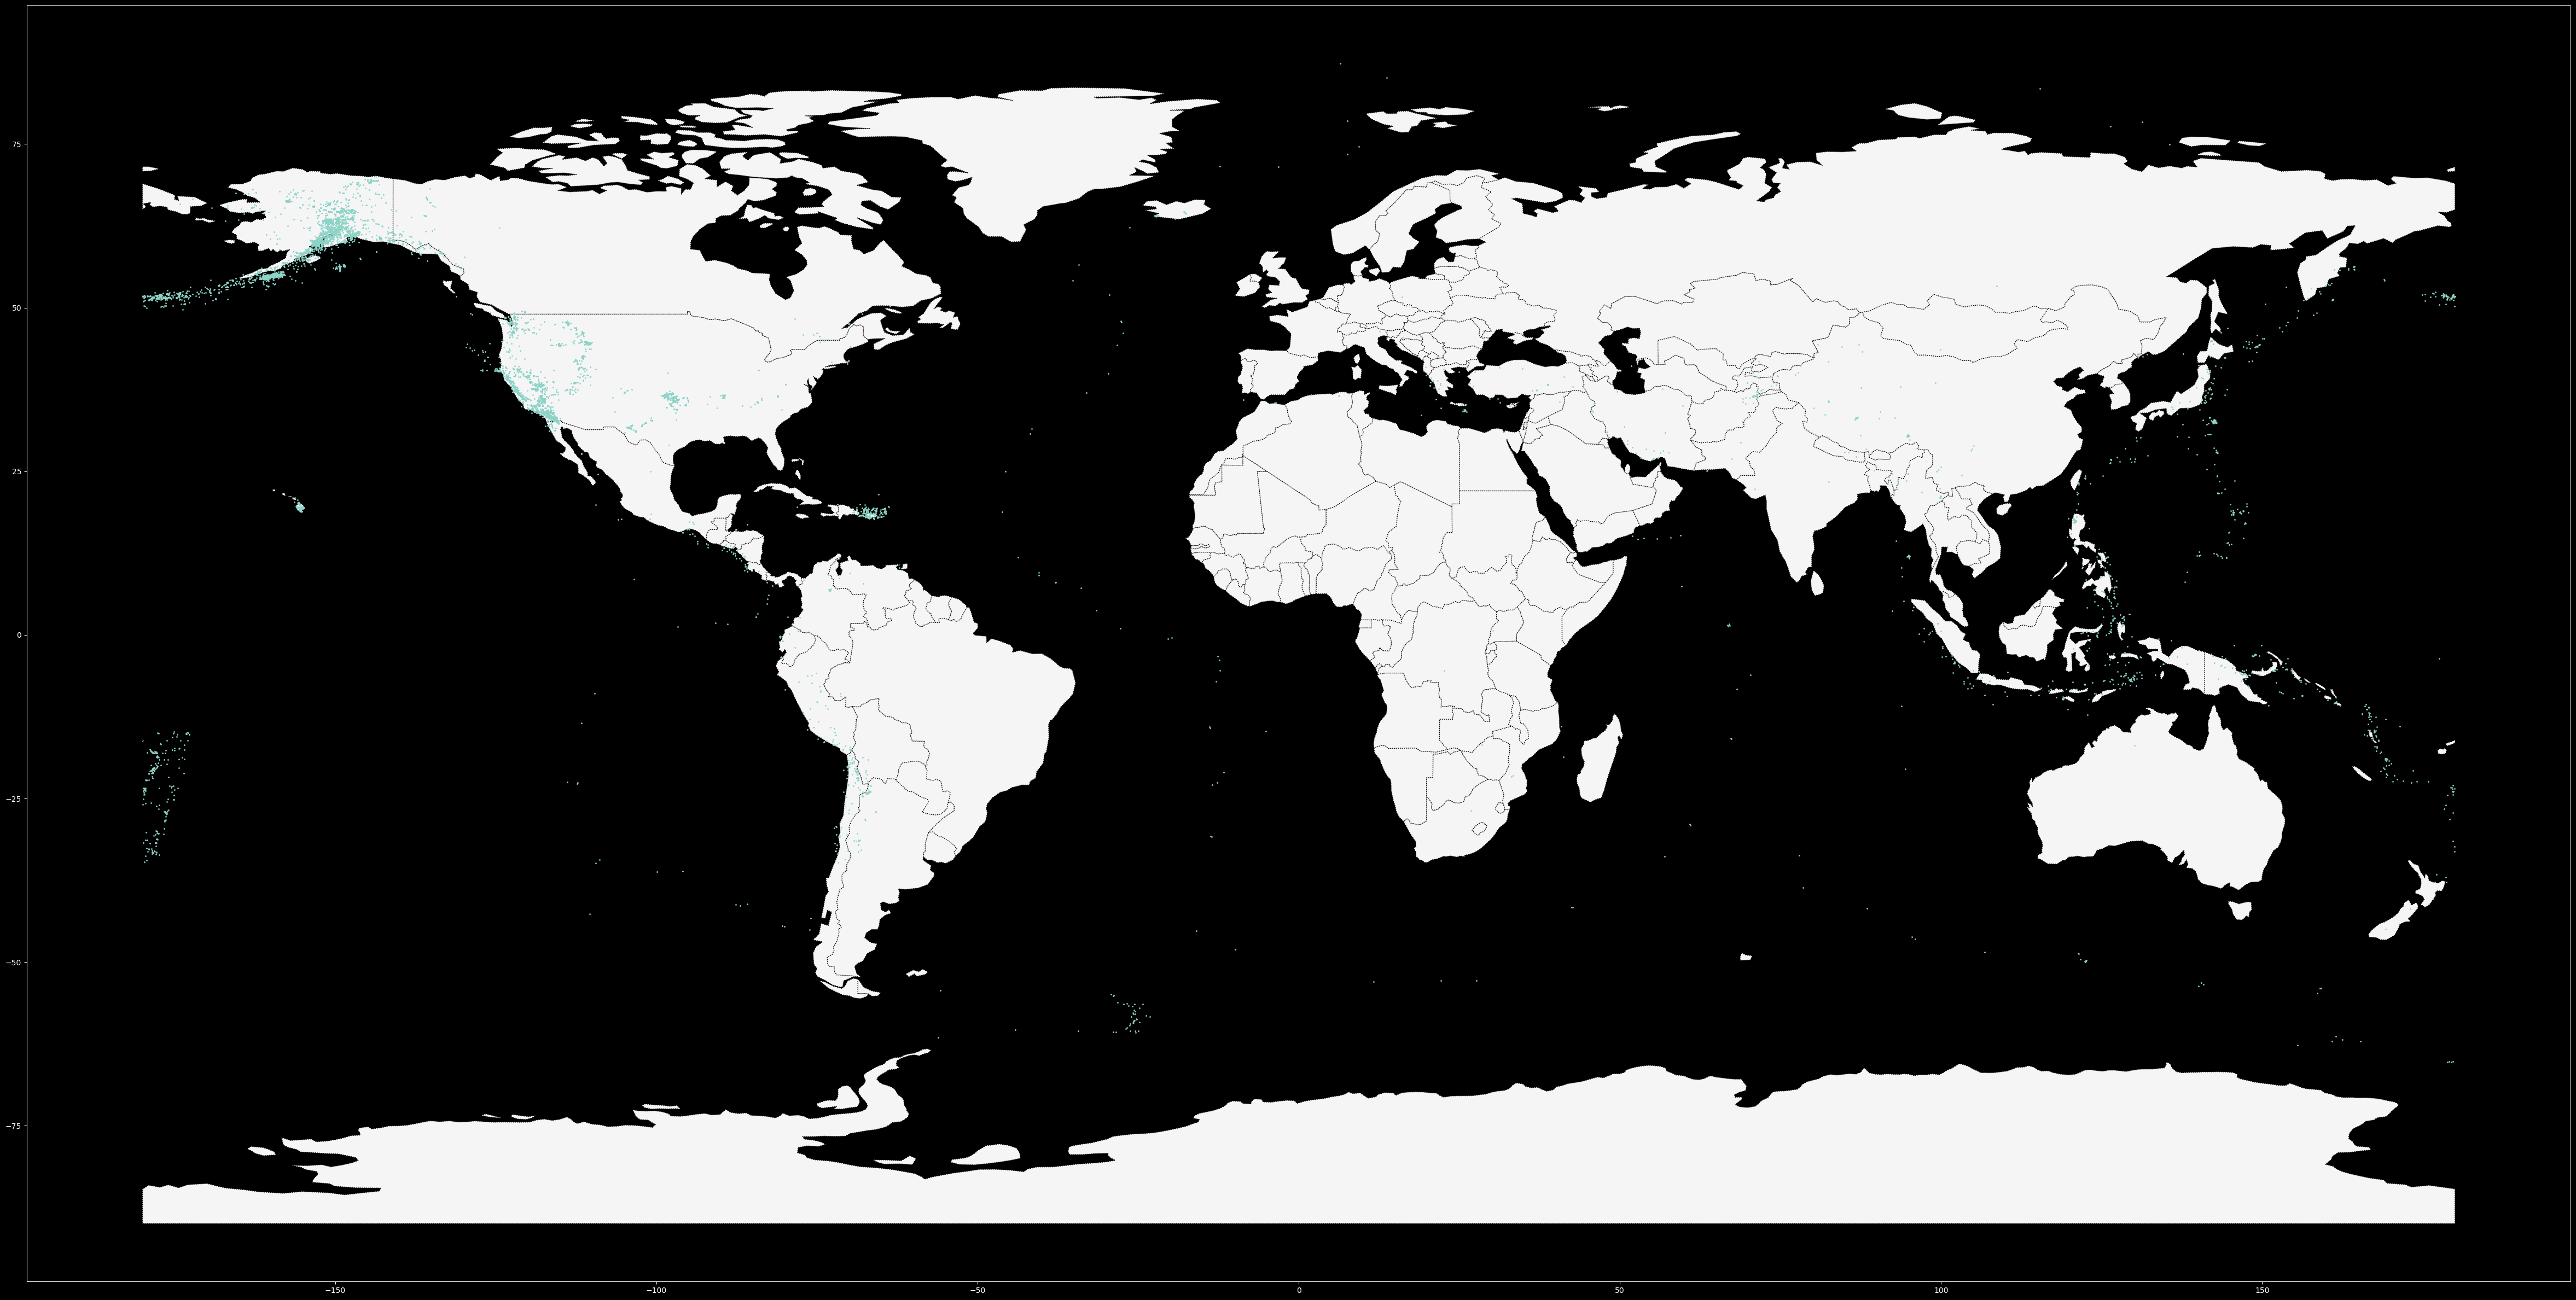

In [46]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [47]:
print(f'Min magnitude: {df["mag"].min()}')
print(f'Max magnitude: {df["mag"].max()}')

Min magnitude: -1.43
Max magnitude: 7.8


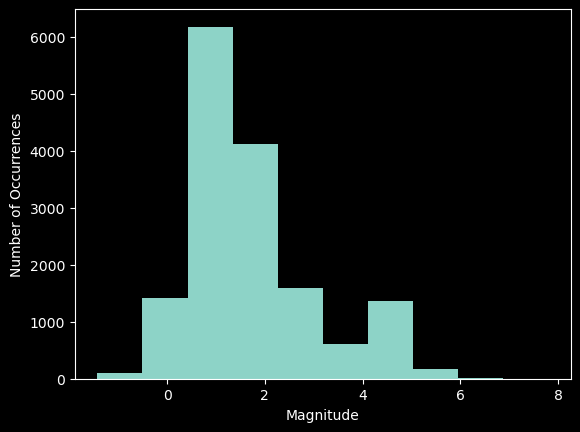

In [48]:
plt.hist(df['mag'])
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

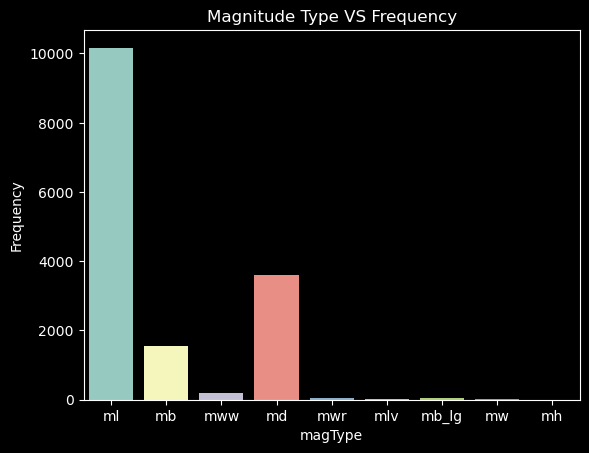

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [49]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [50]:
df.loc[df['mag'] >= 8, 'Class'] = 'Disastrous'
df.loc[(df['mag'] >= 7) & (df['mag'] < 7.9), 'Class'] = 'Major'
df.loc[(df['mag'] >= 6) & (df['mag'] < 6.9), 'Class'] = 'Strong'
df.loc[(df['mag'] >= 5.5) & (df['mag'] < 5.9), 'Class'] = 'Moderate'

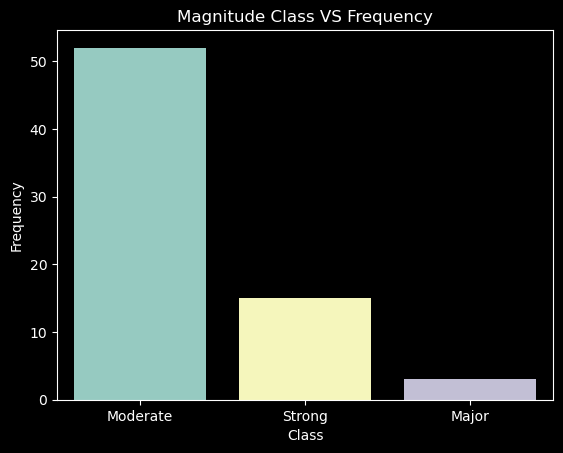

In [51]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

## 2. Data Preparation

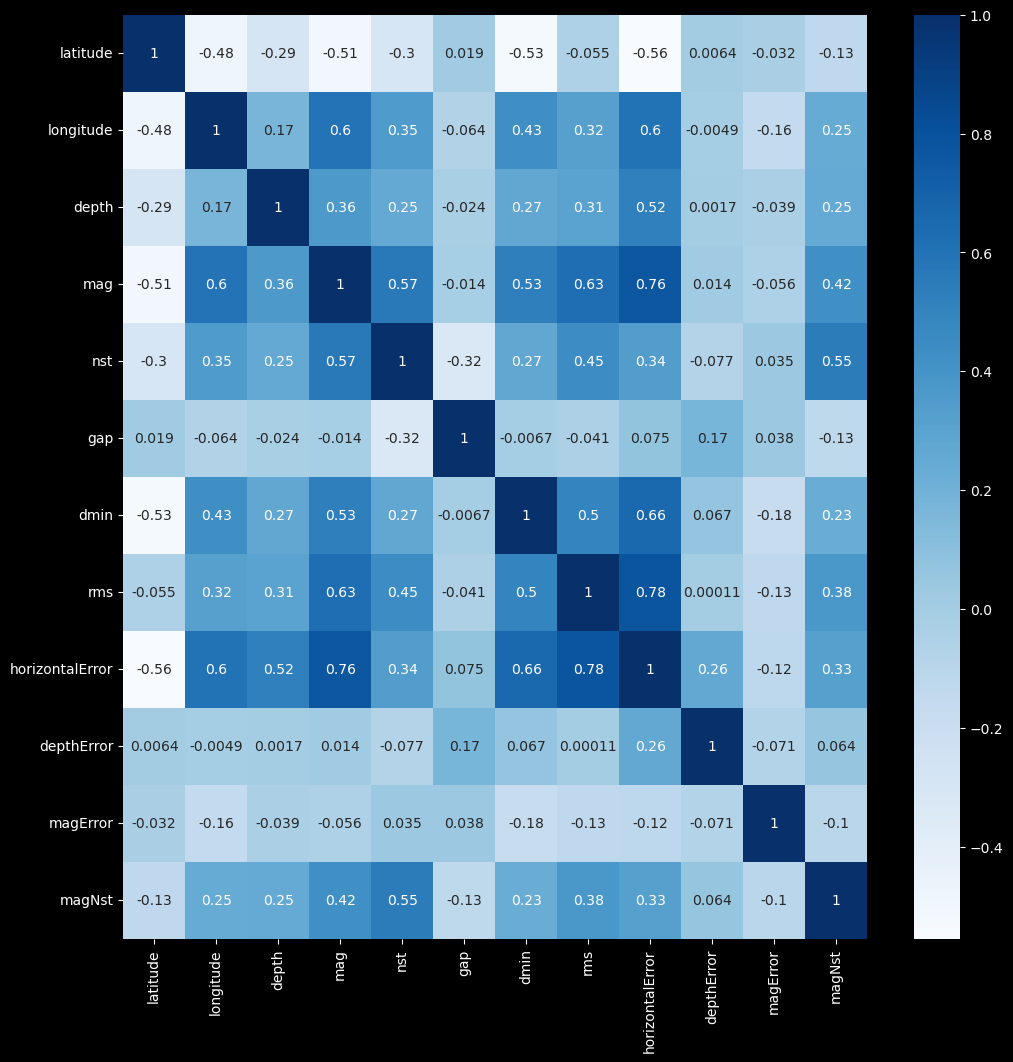

In [52]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [53]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df.drop(to_drop, axis=1, inplace=True)

In [54]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df.drop(column, axis=1, inplace=True) 

In [55]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

columns = ['nst', 'gap', 'dmin', 'mag']

for col in columns:
    df[col] = min_max_scaling(df[col])

df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,depthError
count,15609.000000,15609.000000,15609.000000,15608.000000,11353.000000,12556.000000,11367.000000,15609.000000,15609.000000
mean,37.440961,-107.587888,22.208975,0.339852,0.047084,0.295725,0.016102,0.289966,7.235612
std,18.915086,70.016140,57.789274,0.140831,0.045533,0.168235,0.053068,0.277736,585.071370
min,-65.352200,-179.987200,-3.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.756333,-148.356300,4.000000,0.242687,0.020362,0.169474,0.000586,0.100000,0.470000
50%,38.141500,-118.029800,8.200000,0.303359,0.033937,0.260526,0.001435,0.170000,0.800000
75%,50.999600,-116.313167,14.320000,0.393283,0.056561,0.387792,0.003883,0.440000,1.900000
max,87.349200,180.000000,647.998000,1.000000,1.000000,1.000000,1.000000,2.460000,73091.100000


## 3. Model Training

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15609 entries, 0 to 15608
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   time            15609 non-null  object  
 1   latitude        15609 non-null  float64 
 2   longitude       15609 non-null  float64 
 3   depth           15609 non-null  float64 
 4   mag             15608 non-null  float64 
 5   magType         15608 non-null  object  
 6   nst             11353 non-null  float64 
 7   gap             12556 non-null  float64 
 8   dmin            11367 non-null  float64 
 9   rms             15609 non-null  float64 
 10  net             15609 non-null  object  
 11  id              15609 non-null  object  
 12  updated         15609 non-null  object  
 13  place           15600 non-null  object  
 14  type            15609 non-null  object  
 15  depthError      15609 non-null  float64 
 16  status          15609 non-null  object  
 17  locationSour

In [57]:
features = ['latitude', 'longitude', 'nst', 'gap', 'dmin']
cat_features = ['place', 'net', 'status']
target = 'mag'

In [58]:
test = math.floor(len(df) * 0.3)

df.dropna(axis=0, inplace=True)

df_train = df.iloc[test:]
df_train = df_train[features + cat_features + [target]]

df_test = df.iloc[:test]
df_test = df_test[['time'] + features + cat_features + [target]]

In [59]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [60]:
grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.01],
    'iterations': [1000],
}

model = cb.CatBoostRegressor(
    early_stopping_rounds=10,
    cat_features=cat_features, 
    task_type='GPU',
    devices='0:1',
)

grid_search_result = model.grid_search(
    grid, 
    x_train, 
    y_train,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2763510	test: 0.2712102	best: 0.2712102 (0)	total: 26.9ms	remaining: 26.9s
1:	learn: 0.2633723	test: 0.2583755	best: 0.2583755 (1)	total: 48.4ms	remaining: 24.1s
2:	learn: 0.2510052	test: 0.2460893	best: 0.2460893 (2)	total: 68.4ms	remaining: 22.7s
3:	learn: 0.2392684	test: 0.2344851	best: 0.2344851 (3)	total: 93.8ms	remaining: 23.4s
4:	learn: 0.2281978	test: 0.2235337	best: 0.2235337 (4)	total: 117ms	remaining: 23.2s
5:	learn: 0.2176232	test: 0.2130008	best: 0.2130008 (5)	total: 140ms	remaining: 23.2s
6:	learn: 0.2076167	test: 0.2031295	best: 0.2031295 (6)	total: 166ms	remaining: 23.5s
7:	learn: 0.1981249	test: 0.1937687	best: 0.1937687 (7)	total: 188ms	remaining: 23.4s
8:	learn: 0.1892236	test: 0.1848388	best: 0.1848388 (8)	total: 214ms	remaining: 23.5s
9:	learn: 0.1806884	test: 0.1763666	best: 0.1763666 (9)	total: 233ms	remaining: 23.1s
10:	learn: 0.1725997	test: 0.1683298	best: 0.1683298 (10)	total: 255ms	remaining: 22.9s
11:	learn: 0.1649937	test: 0.1607588	best: 0.160

In [61]:
grid_search_result['params']

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.1}

In [62]:
predictions = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predictions)}')

Accuracy of Model: 0.8335173492249558
Mean Absolute Error: 0.02454937432636485


Accuracy of Model: 0.6169445015002817
Mean Absolute Error: 0.06164430973430526


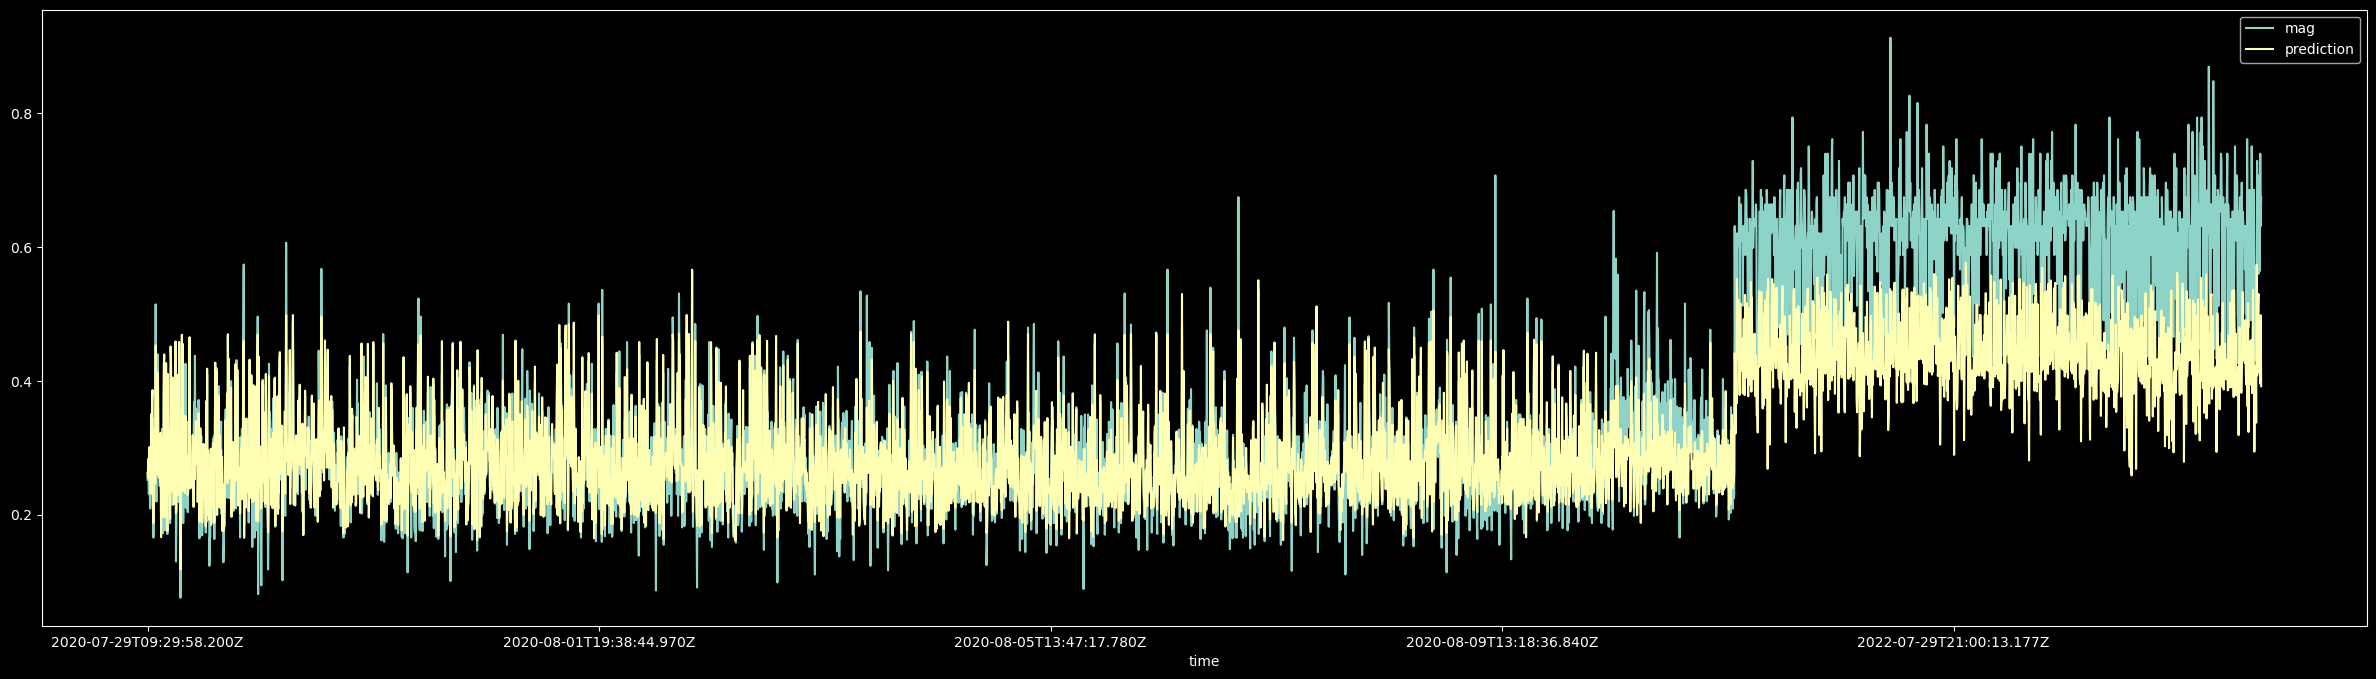

In [63]:
predictions = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], predictions)}')

df_plot = pd.DataFrame({'time': df_test['time'], 'mag': df_test[target], 'prediction': predictions})
df_plot = df_plot[::-1]
df_plot.plot(x='time', figsize=(30, 8))
plt.show()

In [64]:
# model.save_model('../backend/app/ml/model')